# Twitter Data Wrangling Project 


Project goal: Wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

### Gathering : 
    

In [1]:
import pandas as pd 
import numpy as np
import requests 
import tweepy
import re
import matplotlib.pyplot as plt
%matplotlib inline

#### 1. The first gathering task is to read in twitter_archive which was provides as a csv

In [2]:
tweets=pd.read_csv("twitter_archive_.csv")
tweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### 2. The second gathering task is to obtain the picture predictions dataset which is a tsv file stored on udacity servers. 

In [3]:
# get the Data
url= "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response= requests.get(url)

In [12]:
# Create prediction folder to store
import os
folder_name = 'predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [19]:
# Create twitter folder to store
folder_name1 = 'twitter'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [15]:
# Create tsv file and write content in document
with open(os.path.join(folder_name,"predictions.tsv"), mode="wb") as file: 
        file.write(response.content)

In [363]:
# read in tsv
predictions= pd.read_csv("predictions/predictions.tsv",sep = '\t', encoding = 'utf-8')
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### 3. The third gathering step is to get retweet and lfavorite data for the tweets using Tweepy and the Twitter API. 

In [17]:
# Create API object
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [247]:
# These are the ids to use 
real_ids=tweets["tweet_id"]
real_ids[:10]

0    892420643555336193
1    892177421306343426
2    891815181378084864
3    891689557279858688
4    891327558926688256
5    891087950875897856
6    890971913173991426
7    890729181411237888
8    890609185150312448
9    890240255349198849
Name: tweet_id, dtype: int64

In [249]:
# Get Data using API
import json
ranking=0
df_list = []
failed_ids = []
# open file to write json objects from api
with open(os.path.join(folder_name1,'tweets.txt'), mode='w') as outfile:
    for title in real_ids:
        # try-except block since few tweet IDs in the archive may have been deleted
        try: 
            ranking=ranking+1
            print(ranking)
            status=api.get_status(title, tweet_mode='extended')
            favorite_count=status.favorite_count
            retweet_count= status.retweet_count
        
        # Append to list of dictionaries
            df_list.append({'favorite_count': favorite_count,
                        'title': title,
                        'retweet_count': retweet_count})
        
        except Exception as e:
            print(str(ranking) + "_" + str(title) + ": " + str(e))
        
        
        
        # dump the json object corresponding to the tweet collected from the api
        json.dump(status._json, outfile)      #no indent 
        outfile.write('\n')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
20_888202515573088257: [{'code': 144, 'message': 'No status found with that ID.'}]
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
96_873697596434513921: [{'code': 144, 'message': 'No status found with that ID.'}]
97
98
99
100
101
102
102_872668790621863937: [{'code': 144, 'message': 'No status found with that ID.'}]
103
104
105
105_872261713294495745: [{'code': 144, 'message': 'No status found with that ID.'}]
106
107
108
109
110
111
112
113
114
115
116
117
118
119
119_869988702071779329: [{'code': 144, 'message': 'No status found with that ID.'}]
120
121
122
123
124
125
126
127
128
129
130
131
132
133
133_866816280283807744: [{'code': 144, 'message': 'No status found with that ID.'}]
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
15

In [250]:

df = pd.DataFrame(df_list, columns = ['favorite_count', 'title', 'retweet_count'])
df=df.rename(columns={"title": "id"})

In [251]:
df.head()

,favorite_count,id,retweet_count
0,37249,892420643555336193,7980
1,32028,892177421306343426,5926
2,24130,891815181378084864,3913
3,40572,891689557279858688,8135
4,38801,891327558926688256,8813


In [252]:
df.shape

(2333, 3)

In [253]:
df.to_csv("tweets.csv")

In [210]:
df=pd.read_csv("tweets.csv")
df=df.drop("Unnamed: 0", axis=1,)
df.head()
df.shape

(2333, 3)

In [231]:
# As you can see the length of data from API is different than archives due to some outdated Tweets. This code find the outdated ids
s=[]
for b in tweets["tweet_id"].values: 
    if b not in df["id"].values: 
        s.append(b)

In [232]:
# list of the ids
s

[888202515573088257,
 873697596434513921,
 872668790621863937,
 872261713294495745,
 869988702071779329,
 866816280283807744,
 861769973181624320,
 856602993587888130,
 851953902622658560,
 845459076796616705,
 844704788403113984,
 842892208864923648,
 837366284874571778,
 837012587749474308,
 829374341691346946,
 827228250799742977,
 812747805718642688,
 802247111496568832,
 779123168116150273,
 775096608509886464,
 770743923962707968,
 754011816964026368,
 680055455951884288]

In [233]:
len(s)

23

In [239]:
old_id_locations=[]
for ids in s: 
    v=tweets[tweets["tweet_id"]==ids].index[0]
    old_id_locations.append(v)
     

In [242]:
# Drop the bad ids, since I want all the tweets to have retweet and faorite counts. This would be best for my analysis. 
tweets=tweets.drop(old_id_locations)
tweets.shape

(2333, 17)

In [244]:
tweets=tweets.reset_index().drop("index", axis=1)

In [247]:
# There are now no old tweets
p=[]
for b in tweets["tweet_id"].values: 
    if b not in df["id"].values: 
        p.append(b)

In [248]:
p

[]

# Assess

This is where I define the problems to clean and tidy. 

In [245]:
tweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [364]:
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [7]:
df.head()

,favorite_count,id,retweet_count
0,37249,892420643555336193,7980
1,32028,892177421306343426,5926
2,24130,891815181378084864,3913
3,40572,891689557279858688,8135
4,38801,891327558926688256,8813


#### 1. Columns in reply status id and in reply to user_id, along with retweeted status have to many nans. 

In [317]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2356 non-null float64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
url                           

In [365]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 3 columns):
favorite_count    2333 non-null int64
id                2333 non-null int64
retweet_count     2333 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


#### 2.  There are Retweets in Dataset

In [259]:
retweet_row=np.where(tweets.loc[:,["retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp"]].isnull()==False)[0]
retweet_row[:9]

array([19, 19, 19, 32, 32, 32, 36, 36, 36])

In [260]:
# number of retweets
unqiue_rows=np.unique(retweet_row) 
len(unqiue_rows)

181

#### 3. There are urls in tweet text

In [264]:
print(tweets["text"][0])
print(tweets["text"][8])
print(tweets["text"][1000])

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b
PUPPER NOOOOO BEHIND YOUUU 10/10 pls keep this pupper in your thoughts https://t.co/ZPfeRtOX0Q


#### 4. The timestamp is not in datetime

In [265]:
tweets.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

#### 5. There are  numerators whose ratings are puns, and not actual ratings Ratings with decimal values may be wrong. 

In [272]:
puns=tweets[(tweets["rating_numerator"]== 1776) |(tweets["rating_numerator"]== 420)]
print(puns["text"][188])
print(puns["text"][979])
print(puns["text"][2074])

@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY


In [279]:
# Shoud be 9.75 not 75
tweets[tweets["tweet_id"]==786709082849828864]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None


#### 6. Some of the  Expanded Urls are duplicated and some are not from twitter.  

In [283]:
tweets["expanded_urls"][4]

'https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1'

In [311]:
# 103 data points from Vine
np.count_nonzero(tweets["expanded_urls"].str.extract(r'(https://vine)').isnull()==False)

103

#### 7. Some names are incorrect. The values that are lowercase are not names.

In [323]:
lowercase_locations=np.where(tweets["name"].str[0].str.isupper()==False)

In [327]:
bad_names=np.unique(tweets.loc[lowercase_locations]["name"])
print(bad_names)

['a' 'actually' 'all' 'an' 'by' 'getting' 'his' 'incredibly' 'infuriating'
 'just' 'life' 'light' 'mad' 'my' 'not' 'officially' 'old' 'one' 'quite'
 'space' 'such' 'the' 'this' 'unacceptable' 'very']


#### 8. None is not the propper way to describe missing values.  

In [332]:
print(tweets["doggo"].value_counts());
print(tweets["floofer"].value_counts());
print(tweets["pupper"].value_counts());
print(tweets["puppo"].value_counts());


None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


#### Tideness 1:  Dog Stage columns should be combined, since they are one variable 


In [335]:
tweets[["doggo","floofer","pupper","puppo"]].head()

,doggo,floofer,pupper,puppo
0,None,None,None,None
1,None,None,None,None
2,None,None,None,None
3,None,None,None,None
4,None,None,None,None


#### Tideness 2: The retweets / favorites table should be joined  with tweet archives because they provide the same type of information. However, I will not join together the predictions data frame, as this is a different type of observational unit. 

In [336]:
df.head()

,favorite_count,id,retweet_count
0,37249,892420643555336193,7980
1,32028,892177421306343426,5926
2,24130,891815181378084864,3913
3,40572,891689557279858688,8135
4,38801,891327558926688256,8813


# Clean (Quality) 

In [366]:
cleaned_tweets= tweets.copy()
cleaned_predictions= predictions.copy()

#### 1. Delete retweets

In [367]:
# Find retweet ids to drop
retweet_row=np.where(cleaned_tweets.loc[:,["retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp"]].isnull()==False)[0]
unqiue_rows=np.unique(retweet_row) 
dropped_ids=cleaned_tweets["tweet_id"][unqiue_rows]


In [368]:
# Drop them
cleaned_tweets=cleaned_tweets.drop(unqiue_rows).reset_index().drop("index", axis=1)
cleaned_tweets.shape

(2168, 17)

In [369]:
# Check they are no more retweets
np.where(cleaned_tweets.loc[:,["retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp"]].isnull()==False)[0]

array([], dtype=int64)

In [370]:
len(unqiue_rows)

165

In [371]:
# Check whether retweets are present in retweet/favorite dataframe. 
q=[]
for b in df["id"].values: 
    if b  not in cleaned_tweets["tweet_id"].values: 
        q.append(b)

In [274]:
len(q)

165

In [278]:
# Check whether they are the same ids. 
sum(q== dropped_ids)

165

In [372]:
# Find the locations and drop them. 
df_retweet_locations=[]
for ids in q: 
    v=df[df["id"]==ids].index[0]
    df_retweet_locations.append(v)

In [373]:
df=df.drop(df_retweet_locations).reset_index().drop("index", axis=1)
df.shape

(2168, 3)

#### 2. Drop Columns  reply status id  in reply to user_id, along with retweeted status columns as they have too many nans. 

In [374]:
cleaned_tweets=cleaned_tweets.drop(["in_reply_to_status_id","in_reply_to_user_id","retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp"], axis=1)

In [375]:
cleaned_tweets.shape

(2168, 12)

#### 3. Remove urls in tweet text

In [376]:
cleaned_tweets["text"]=cleaned_tweets["text"].str.replace(r'(http\S+)',"")

In [377]:
print(cleaned_tweets["text"][0])
print(cleaned_tweets["text"][8])
print(cleaned_tweets["text"][1000])

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 
This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek 
We normally don't rate marshmallows but this one appears to be flawlessly toasted so I'll make an exception. 10/10 


#### 4.  Convert timestamp to Datetime

In [378]:
cleaned_tweets["timestamp"]=pd.to_datetime(cleaned_tweets["timestamp"])

In [379]:
cleaned_tweets.dtypes

tweet_id                       int64
timestamp             datetime64[ns]
source                        object
text                          object
expanded_urls                 object
rating_numerator               int64
rating_denominator             int64
name                          object
doggo                         object
floofer                       object
pupper                        object
puppo                         object
dtype: object

#### 5. Replace numerators whose ratings are puns (420, and 1776), and not actual ratings with median rating. Fix ratings with decimal values with regex. 

In [380]:
median= np.median(cleaned_tweets["rating_numerator"])
median

11.0

In [381]:
cleaned_tweets["rating_numerator"]=cleaned_tweets['rating_numerator'].replace([420, 1776], median)

In [382]:
np.where((cleaned_tweets["rating_numerator"]==420) |(cleaned_tweets["rating_numerator"]==1776))

(array([], dtype=int64),)

In [383]:
# Dealing with decimals
cleaned_tweets["rating_numerator"]=cleaned_tweets["text"].str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)

In [384]:
cleaned_tweets[cleaned_tweets["tweet_id"]==786709082849828864]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
554,786709082849828864,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10,Logan,None,None,None,None


#### 6. Obtain all twitter urls using regex. 

In [385]:
urls=cleaned_tweets["expanded_urls"].str.extract(r'(https://twitter.com/.+?/status/\d{18}?)')[0]

In [386]:
len(urls[0])

55

In [387]:
# Find the number of urls from twitter
nan_index=np.where(urls.isnull()==False)[0]
present=urls[nan_index]
len(present)

2016

In [388]:
# The Followiing code compares teh lengths of urls before ad after. As you can tell by the histograms the length now hovers around 55, and is not as spread out indicated success. 
lengths=[]
for i in present:
     lengths.append(len(i))


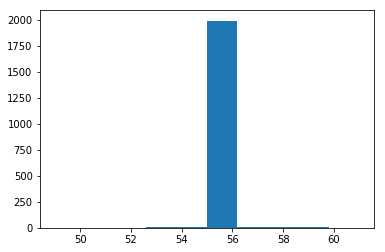

In [389]:
plt.hist(lengths);

In [390]:
nan_indexs=np.where(cleaned_tweets["expanded_urls"].isnull()==False)[0]
presents=cleaned_tweets["expanded_urls"][nan_index]
len(presents)

2016

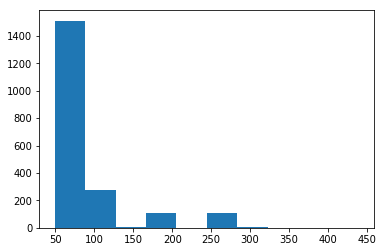

In [391]:
old_lengths=[]
for i in presents:
     old_lengths.append(len(i))
plt.hist(old_lengths);

In [392]:
# No more urls form vine. All urls from twitter. 
np.count_nonzero(urls.str.extract(r'(https://vine)').isnull()==False)

0

In [393]:
# make change
cleaned_tweets["expanded_urls"]= urls

#### 7. Mask the Lowercase names with NaN. 

In [394]:
n=cleaned_tweets["name"].mask(cleaned_tweets["name"].str[0].str.isupper()==False)

In [395]:
cleaned_tweets["name"]=n

In [396]:
np.where(cleaned_tweets["name"].str[0].str.isupper()==False)

(array([], dtype=int64),)

#### 8. Replace None with Nan

In [397]:
cleaned_tweets["name"]=cleaned_tweets["name"].replace({"None":np.nan})

In [398]:
np.where(cleaned_tweets.where( cleaned_tweets["name"]=="None").isnull()== False)

(array([], dtype=int64), array([], dtype=int64))

# Clean(Tideness)

In [399]:
final_tweets= cleaned_tweets.copy()
final_predictions= predictions.copy()

### 1. Joining the two Tables

In [330]:
final_tweets.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [331]:
df.head()

,favorite_count,id,retweet_count
0,37249,892420643555336193,7980
1,32028,892177421306343426,5926
2,24130,891815181378084864,3913
3,40572,891689557279858688,8135
4,38801,891327558926688256,8813


In [400]:
merged=final_tweets.merge(df ,left_on="tweet_id", right_on="id", how="left")
merged.shape

(2168, 15)

In [401]:
merged.dtypes

tweet_id                       int64
timestamp             datetime64[ns]
source                        object
text                          object
expanded_urls                 object
rating_numerator              object
rating_denominator             int64
name                          object
doggo                         object
floofer                       object
pupper                        object
puppo                         object
favorite_count                 int64
id                             int64
retweet_count                  int64
dtype: object

In [416]:
merged=merged.drop("id", axis=1)

### 2. Using pd.melt to unpivot the dog stages

In [402]:
melt=pd.melt(merged, id_vars=['tweet_id'], value_vars=['doggo', 'floofer',"pupper","puppo",],var_name='DogStages', value_name='Stage')
melt.head()

,tweet_id,DogStages,Stage
0,892420643555336193,doggo,None
1,892177421306343426,doggo,None
2,891815181378084864,doggo,None
3,891689557279858688,doggo,None
4,891327558926688256,doggo,None


In [403]:
melt_counts=pd.DataFrame(melt["tweet_id"].value_counts())
melt_counts.head()

,tweet_id
749075273010798592,4
700847567345688576,4
857029823797047296,4
710997087345876993,4
841320156043304961,4


In [404]:
melt[melt["tweet_id"]== 890240255349198849]

,tweet_id,DogStages,Stage
9,890240255349198849,doggo,doggo
2177,890240255349198849,floofer,None
4345,890240255349198849,pupper,None
6513,890240255349198849,puppo,None


In [405]:
melt=melt.replace("None", np.nan)

In [406]:
melt[melt["tweet_id"]== 890240255349198849]

,tweet_id,DogStages,Stage
9,890240255349198849,doggo,doggo
2177,890240255349198849,floofer,NaN
4345,890240255349198849,pupper,NaN
6513,890240255349198849,puppo,NaN


In [407]:
melt=melt.dropna()
melt.head()

,tweet_id,DogStages,Stage
9,890240255349198849,doggo,doggo
40,884162670584377345,doggo,doggo
89,872967104147763200,doggo,doggo
96,871515927908634625,doggo,doggo
97,871102520638267392,doggo,doggo


In [408]:
melt=melt.drop("DogStages", axis=1)

In [409]:
merged=merged.merge(melt ,left_on="tweet_id", right_on="tweet_id", how="left").drop(["doggo","floofer","pupper","puppo"], axis=1)
merged.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,id,retweet_count,Stage
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,37249,892420643555336193,7980,NaN
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,32028,892177421306343426,5926,NaN
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,24130,891815181378084864,3913,NaN
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,40572,891689557279858688,8135,NaN
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,38801,891327558926688256,8813,NaN


In [410]:
# There are now more rows. 
merged.shape

(2180, 12)

In [411]:
sum(merged.duplicated())

0

In [412]:
# These additional rows are caused since some IDS have multpile dog stages. As I do not know the correct stage, I will leave both in.
merged["tweet_id"].value_counts()[:12]

855851453814013952    2
759793422261743616    2
802265048156610565    2
817777686764523521    2
785639753186217984    2
741067306818797568    2
854010172552949760    2
751583847268179968    2
781308096455073793    2
733109485275860992    2
801115127852503040    2
808106460588765185    2
Name: tweet_id, dtype: int64

In [413]:
merged[merged["tweet_id"]== 855851453814013952]["Stage"]

164    doggo
165    puppo
Name: Stage, dtype: object

In [3]:
# Move predictions dataset and merged twitter dataset to SQL database. 
from sqlalchemy import create_engine
engine = create_engine('sqlite:///twitter_final.db')

In [462]:
merged.to_sql('tweet_data', engine, index=False)
final_predictions.to_sql('prediction_data', engine, index=False)

In [4]:
merged=pd.read_sql('SELECT * FROM tweet_data', engine)

# Analysis

In [5]:
merged.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorite_count,retweet_count,Stage
0,892420643555336193,2017-08-01 16:23:56.000000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,37249,7980,None
1,892177421306343426,2017-08-01 00:17:27.000000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,32028,5926,None
2,891815181378084864,2017-07-31 00:18:03.000000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,24130,3913,None
3,891689557279858688,2017-07-30 15:58:51.000000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,40572,8135,None
4,891327558926688256,2017-07-29 16:00:24.000000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,38801,8813,None


Text(0,0.5,'Retweet Count')

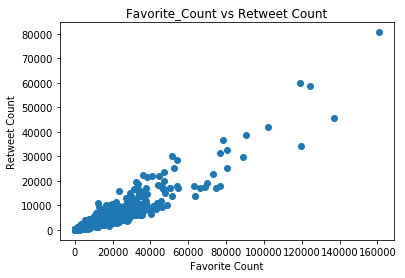

In [6]:
plt.scatter(merged["favorite_count"], merged["retweet_count"]);
plt.title("Favorite_Count vs Retweet Count")
plt.xlabel("Favorite Count")
plt.ylabel("Retweet Count")


Insight 1: There is a strong correlation between favorite count and retweet count. 

In [7]:
stages=merged.groupby("Stage").mean().reset_index()
stages

,Stage,tweet_id,rating_denominator,favorite_count,retweet_count
0,doggo,7.936887e+17,10.0,17043.953488,5839.372093
1,floofer,7.656406e+17,10.0,10977.500000,3711.500000
2,pupper,7.211049e+17,10.0,7056.448718,2310.876068
3,puppo,8.089602e+17,10.0,21495.440000,6362.000000


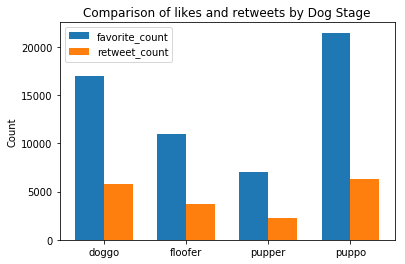

In [8]:
labels = stages["Stage"]
favorite = stages["favorite_count"]
retweet = stages["retweet_count"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, favorite, width, label='favorite_count')
rects2 = ax.bar(x + width/2, retweet, width, label='retweet_count')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Comparison of likes and retweets by Dog Stage')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

Insight 2: Puppo seems to have more likes and more retweets

In [9]:
len_of_text=[]
for i in merged["text"]: 
    len_of_text.append(len(i))

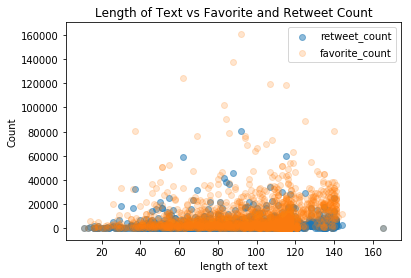

In [10]:
plt.scatter(len_of_text, merged["retweet_count"], alpha=0.5);
plt.scatter(len_of_text, merged["favorite_count"], alpha=0.2);
plt.legend()
plt.title("Length of Text vs Favorite and Retweet Count")
plt.xlabel("length of text")
plt.ylabel("Count");

Insight 3: There is no significant relationship between length of tweet and retweet count or favorite count. 

In [11]:
merged["name"].value_counts()[:4]

Charlie    10
Oliver     10
Cooper     10
Lucy       10
Name: name, dtype: int64

Insight 4: The most common dog names are Charlie, Oliver, Cooper, and Lucy. 